In [32]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import Naive
import matplotlib.pyplot as plt
import statsforecast as sf
from utilsforecast.plotting import plot_series
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_excel('Downloads/CMO-Historical-Data-Monthly.xlsx', sheet_name='Monthly Prices')
df_clean = df.drop([0, 1, 2, 3, 4]) 
new_columns = df.iloc[3, 1:].tolist()  
df_clean.columns = ['Month'] + new_columns  
df_clean['Month'] = pd.to_datetime(df_clean['Month'], format='%YM%m')
df_clean.set_index('Month', inplace=True)
df_clean = df_clean.sort_index()
df_clean = df_clean.dropna(axis=1, how='all')

df = df_clean
df.index = df.index.to_period('M')
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,"Crude oil, average","Crude oil, Brent","Crude oil, Dubai","Crude oil, WTI","Coal, Australian","Coal, South African **","Natural gas, US","Natural gas, Europe","Liquefied natural gas, Japan",Natural gas index,...,Aluminum,"Iron ore, cfr spot",Copper,Lead,Tin,Nickel,Zinc,Gold,Platinum,Silver
Month,,,,,,,,,,,,,,,,,,,,,
1960-01,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,715.40,206.10,2180.40,1631.00,260.80,35.27,83.50,0.9137
1960-02,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,728.19,203.70,2180.40,1631.00,244.90,35.27,83.50,0.9137
1960-03,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,684.94,210.30,2173.80,1631.00,248.70,35.27,83.50,0.9137
1960-04,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,723.11,213.60,2178.20,1631.00,254.60,35.27,83.50,0.9137
1960-05,1.630000,1.630,1.63,NaN,NaN,NaN,0.1400,0.404774,NaN,NaN,...,511.471832,11.42,684.75,213.40,2162.70,1631.00,253.80,35.27,83.50,0.9137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11,72.291667,74.395,72.79,69.69,142.12,106.82,2.1045,13.926400,12.822731,100.448776,...,2582.190000,100.50,9075.73,1987.53,29654.89,15723.06,3004.20,2651.13,965.53,31.0940
2024-12,72.311000,73.833,73.31,69.79,129.81,105.47,3.0229,13.856621,12.640616,111.146139,...,2541.020000,102.21,8916.32,1990.43,28864.99,15444.89,3034.16,2648.01,937.88,30.7640
2025-01,78.162000,79.206,80.14,75.14,118.60,103.28,4.0991,14.663512,13.193106,128.425081,...,2573.400000,99.58,8991.41,1921.36,29612.36,15394.14,2818.96,2709.69,949.23,30.4110


In [38]:
def get_mape(ts_num, forecaster):
    test_start = '2024-01'
    test_end = '2024-12'
    series = df.iloc[:, ts_num].dropna()
    train = series[series.index < test_start]
    test = series[(series.index >= test_start) & (series.index <= test_end)]
    forecaster.fit(train)
    fh = ForecastingHorizon(test.index, is_relative=False)
    y_pred = forecaster.predict(fh)
    return mean_absolute_percentage_error(test, y_pred)

In [40]:
ARIMA = AutoARIMA(
    sp=12,
    seasonal=False,
    stepwise=False,       
    n_jobs=-1,            
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)

SARIMA = AutoARIMA(
    sp=12,
    seasonal=True,
    stepwise=False,      
    n_jobs=-1,          
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)

ETS = AutoETS(auto=True, sp=12, n_jobs=-1)

In [48]:
results = []
models = [('ETS', ETS), ('ARIMA', ARIMA), ('SARIMA', SARIMA)]
for i in range(len(df.columns)):
    verdicts = {}
    try:
        for model in models:
            verdicts[model[0]] = get_mape(i, model[1])
    except:
        pass
    results.append(verdicts)
    print(i)
    print(verdicts)

0
{'ETS': 0.05041594454150172, 'ARIMA': 0.0771481043446248, 'SARIMA': 0.10215867907136476}
1
{'ETS': 0.05063381582071396, 'ARIMA': 0.07430411363761352, 'SARIMA': 0.1008265262310803}
2
{'ETS': 0.05651802525515215, 'ARIMA': 0.07249933292832034, 'SARIMA': 0.07249933292832034}
3
{'ETS': 0.0667070345126737, 'ARIMA': 0.07871980913916876, 'SARIMA': 0.10407495814893235}
4
{'ETS': 0.058890930939923286, 'ARIMA': 0.04360372163649562, 'SARIMA': 0.04360372163649562}
5
{'ETS': 0.013723103707384969, 'ARIMA': 0.0367207759091655, 'SARIMA': 0.0367207759091655}
6
{'ETS': 0.27083776538282783, 'ARIMA': 0.2655210512784956, 'SARIMA': 0.2655210512784956}
7
{'ETS': 0.16014121900298572, 'ARIMA': 0.21845047754877375, 'SARIMA': 0.21845047754877375}
8
{'ETS': 0.23599533206025414, 'ARIMA': 0.20345532774304068, 'SARIMA': 0.20345532774304068}
9
{'ETS': 0.1383881648304073, 'ARIMA': 0.22707140800133338, 'SARIMA': 0.22707140800133338}
10
{'ETS': 0.3911542664354668, 'ARIMA': 0.3873447962845413, 'SARIMA': 0.38734479628454

ValueError: `fh` must not be empty

In [52]:
for i in range(len(results), len(df.columns)):
    verdicts = {}
    try:
        for model in models:
            verdicts[model[0]] = get_mape(i, model[1])
    except:
        pass
    results.append(verdicts)
    print(i)
    print(verdicts)

28
{}
29
{'ETS': 0.06358203341904645, 'ARIMA': 0.08884198140696788, 'SARIMA': 0.08884198140696788}
30
{}
31
{'ETS': 0.17215894497159331, 'ARIMA': 0.13210555315700256, 'SARIMA': 0.13210555315700256}
32
{'ETS': 0.14214324196431935, 'ARIMA': 0.11501559303355352, 'SARIMA': 0.11501559303355352}
33
{'ETS': 0.2459436944904859, 'ARIMA': 0.06781327835509732, 'SARIMA': 0.06781327835509732}
34
{'ETS': 0.14034498893272282, 'ARIMA': 0.047531099057725894, 'SARIMA': 0.047531099057725894}
35
{'ETS': 0.12042490797005619, 'ARIMA': 0.10468984063284692, 'SARIMA': 0.13677464548464288}
36
{'ETS': 0.03219773652068573, 'ARIMA': 0.08609788730938174, 'SARIMA': 0.08609788730938174}
37
{'ETS': 0.06447061378378922, 'ARIMA': 0.0208198717817173, 'SARIMA': 0.05155626608077709}
38
{'ETS': 0.437133999207306, 'ARIMA': 0.37530807969848023, 'SARIMA': 0.4019715332364577}
39
{'ETS': 0.10491742226115701, 'ARIMA': 0.1511294443501606, 'SARIMA': 0.1826642762243247}
40
{'ETS': 0.17782568635645804, 'ARIMA': 0.1853680203319068, 'S

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50
{'ETS': 0.012338306841000056, 'ARIMA': 0.011605120926529135, 'SARIMA': 0.015185517394327767}
51
{'ETS': 0.010756719321742882, 'ARIMA': 0.011900596696162965, 'SARIMA': 0.011900596696162965}
52
{'ETS': 0.0883395746233066, 'ARIMA': 0.08053318565464156, 'SARIMA': 0.08053318565464156}
53
{'ETS': 0.0612263271122326, 'ARIMA': 0.12273796465849128, 'SARIMA': 0.12273796465849128}
54
{'ETS': 0.15321713933655498, 'ARIMA': 0.19056772058572444, 'SARIMA': 0.19056772058572444}
55
{'ETS': 0.2249736334196012, 'ARIMA': 0.2672938256495085, 'SARIMA': 0.2674949611489675}
56
{'ETS': 0.09355426636990509, 'ARIMA': 0.6184602182413752, 'SARIMA': 0.49858950268673485}
57
{'ETS': 0.07311269983377683, 'ARIMA': 0.04475149203829653, 'SARIMA': 0.04475149203829653}
58
{'ETS': 0.06163367386918999, 'ARIMA': 0.052804100190891136, 'SARIMA': 0.052804100190891136}
59
{'ETS': 0.11699850663439253, 'ARIMA': 0.06737301418851735, 'SARIMA': 0.10000653184533843}
60
{'ETS': 0.028818579321080656, 'ARIMA': 0.041682369660499735, 'SAR

In [62]:
metrics_df = pd.DataFrame(results)

# Агрегаты
stats = pd.DataFrame({
    'mean': metrics_df.mean(),
    'median': metrics_df.median(),
    'max': metrics_df.max()
})

stats = 100 * stats
stats.columns.name = 'Model'
stats.index.name = 'Aggregate'
stats = stats.round(2)
stats

Model,mean,median,max
Aggregate,,,
ETS,11.99,9.53,43.71
ARIMA,12.86,9.94,61.85
SARIMA,12.79,10.15,49.86


In [58]:
metrics_df.mean()

Aggregate
ETS       0.119872
ARIMA     0.128623
SARIMA    0.127922
dtype: float64

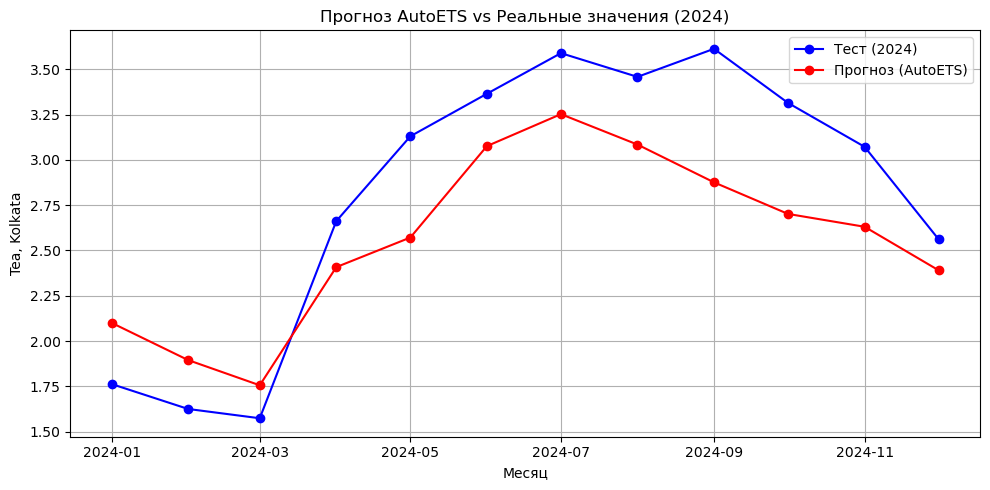

MAPE (2024): 0.1362 (13.62%)


In [12]:
num = 15

test_start = '2024-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index >= test_start) & (series.index <= test_end)]

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)  # sp=12 для месячных данных
forecaster.fit(train)
fh = ForecastingHorizon(test.index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, 'o-', color='blue', label="Тест (2024)")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, 'o-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз AutoETS vs Реальные значения (2024)")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mape = mean_absolute_percentage_error(test, y_pred)
print(f"MAPE (2024): {mape:.4f} ({mape*100:.2f}%)")


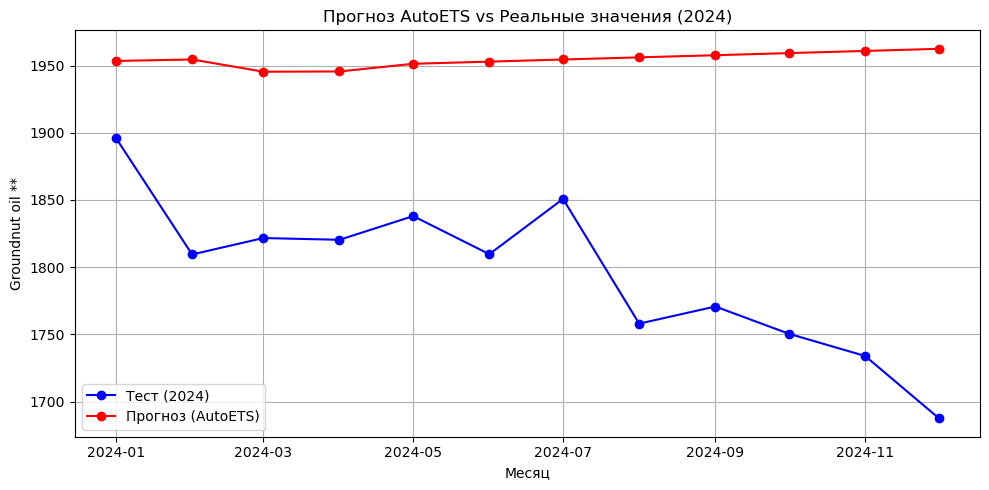

MAPE (2024): 0.0896 (8.96%)


In [29]:
num = 20

test_start = '2024-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index >= test_start) & (series.index <= test_end)]

forecaster = AutoARIMA(
    sp=12,
    seasonal=True,
    stepwise=False,       
    n_jobs=-1,           
    trace=False,
    error_action='ignore', 
    suppress_warnings=True
)
forecaster.fit(train)
fh = ForecastingHorizon(test.index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, 'o-', color='blue', label="Тест (2024)")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, 'o-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз AutoETS vs Реальные значения (2024)")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mape = mean_absolute_percentage_error(test, y_pred)
print(f"MAPE (2024): {mape:.4f} ({mape*100:.2f}%)")


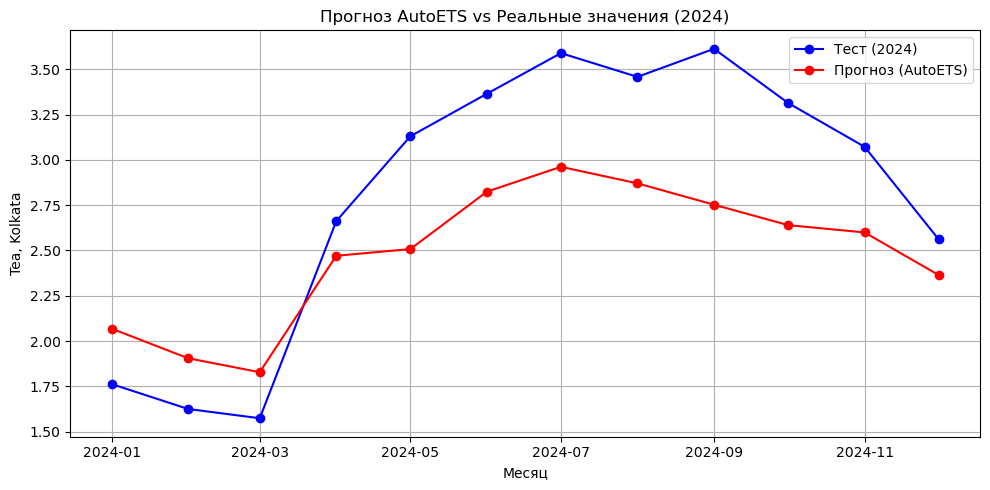

MAPE (2024): 0.1630 (16.30%)


In [30]:
num = 15

test_start = '2024-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index >= test_start) & (series.index <= test_end)]

forecaster.fit(train)
fh = ForecastingHorizon(test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, 'o-', color='blue', label="Тест (2024)")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, 'o-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз AutoETS vs Реальные значения (2024)")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mape = mean_absolute_percentage_error(test, y_pred)
print(f"MAPE (2024): {mape:.4f} ({mape*100:.2f}%)")


07:37:08 - cmdstanpy - INFO - Chain [1] start processing
07:37:08 - cmdstanpy - INFO - Chain [1] done processing


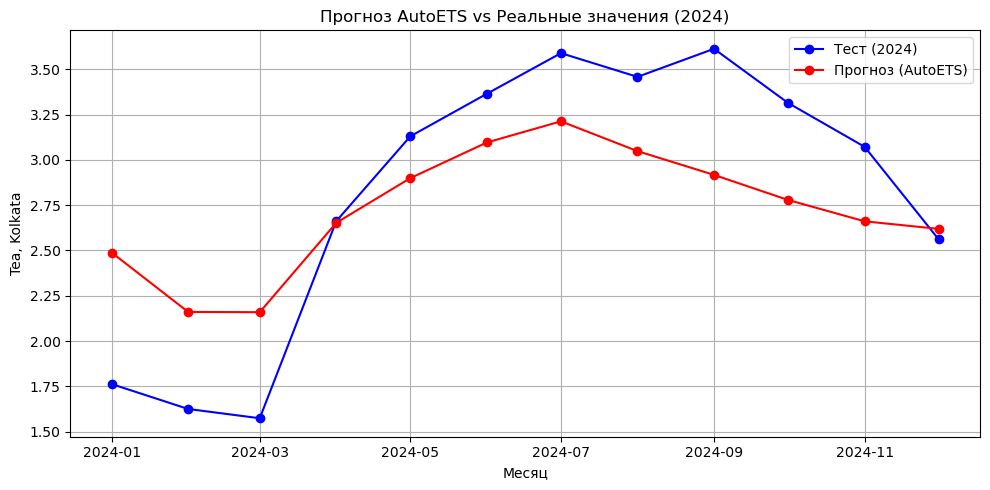

MAPE (2024): 0.1671 (16.71%)


In [37]:
num = 15

test_start = '2024-01'
test_end = '2024-12'

series = df.iloc[:, num].dropna()
train = series[series.index < test_start]
test = series[(series.index >= test_start) & (series.index <= test_end)]

forecaster = Prophet(
    seasonality_mode='multiplicative', 
    n_changepoints=int(len(train) / 12),  
    yearly_seasonality=True
)
forecaster.fit(train)
fh = ForecastingHorizon(test.index, is_relative=False)
y_pred = forecaster.predict(fh)


plt.figure(figsize=(10, 5))
plt.plot(test.index.to_timestamp(), test.values, 'o-', color='blue', label="Тест (2024)")
plt.plot(y_pred.index.to_timestamp(), y_pred.values, 'o-', color='red', label="Прогноз (AutoETS)")
plt.title("Прогноз AutoETS vs Реальные значения (2024)")
plt.xlabel("Месяц")
plt.ylabel(df.columns[num])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


mape = mean_absolute_percentage_error(test, y_pred)
print(f"MAPE (2024): {mape:.4f} ({mape*100:.2f}%)")
